In [2]:
import sys
import argparse
import random
import openslide
import numpy as np
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import utility_functions as uf
import pandas as pd
import os
import utility_functions as uf

In [131]:
#checking the data oringinal method
index = 2000
lib = torch.load("/home/weber50432/AML_image_processing/lib/NPM1_patch_20000/NPM1_patch_20000_test_data.pt")
# lib = torch.load("/home/weber50432/AML_image_processing/lib/NPM1_patch_500_balanced/NPM1_patch_500_balanced_test_data.pt")
slidename = lib["slides"]
print(lib["slides"][:5])
print(type(lib["grid"][:5]))
# print(lib["grid"][:5][0])
print(lib["targets"][:5])
# print(len(lib["slides"]))
grid = []
slideIDX = []
count = 0
for i,g in enumerate(lib['grid']):
  grid.extend(g)
  slideIDX.extend([i]*len(g))
print(slideIDX[0])
print(type(grid))
print(grid[0])
slide_num = slidename[1].split("_")[0]
slide_path = f"/staging/biology/b08611005/ROI_level0_pixel512/{slide_num}/"
print(slide_path)
patch_path = slide_path + grid[index]
print(patch_path)

['/staging/biology/b08611005/ROI_level0_pixel512/A29', '/staging/biology/b08611005/ROI_level0_pixel512/A60', '/staging/biology/b08611005/ROI_level0_pixel512/A99', '/staging/biology/b08611005/ROI_level0_pixel512/A102', '/staging/biology/b08611005/ROI_level0_pixel512/A106']
<class 'list'>
[0, 0, 1, 0, 0]
0
<class 'list'>
A29_32389.png
/staging/biology/b08611005/ROI_level0_pixel512//staging/biology/b08611005/ROI/
/staging/biology/b08611005/ROI_level0_pixel512//staging/biology/b08611005/ROI/A29_40665.png


['A858', 'A902', 'A444', 'A1121', 'A378', 'A660', 'A726', 'A612', 'A821', 'A716']
/home/exon_storage1/aml_slide/single_cell_image/A783/Neutrophil/A783_16020_1.png
(64, 64)


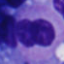

In [11]:
#checking the data
# lib = torch.load("/home/weber50432/AML_image_processing/lib/NPM1_patch_20000/NPM1_patch_20000_test_data.pt")
lib = torch.load("/home/weber50432/AML_image_processing/lib/NPM1_cell_test/NPM1_train_data.pt")
slidename = lib["slides"]
patches_path = "/home/exon_storage1/aml_slide/single_cell_image/"
print(slidename[:10])
# print(lib["grid"][:5])
# print(lib["targets"][:5])
grid = []
slideIDX = []
count = 0
for i,g in enumerate(lib['grid']):
  grid.extend(g)
  slideIDX.extend([i]*len(g))
# print(slideIDX[index])
# print(grid[index])
index = random.randint(0, len(slideIDX))
slide_num = slidename[slideIDX[index]].split("_")[0]
slide_path = f"{patches_path}{slide_num}/"
patch_path = slide_path+ grid[index]
print(patch_path)
img =Image.open(patch_path).convert('RGB')
print(img.size)
img.show()

In [35]:
# check best epoch in .pth file
loaded_obj = torch.load("/home/weber50432/AML_image_processing/MIL_slide_level/output/NPM1_balance_K30/checkpoint_best.pth")
print(loaded_obj['epoch'])
print(loaded_obj['best_acc'])
loaded_obj.keys()


50
0.6419413919413919


dict_keys(['epoch', 'state_dict', 'best_acc', 'optimizer'])

In [5]:
libraryfile = "/home/weber50432/AML_image_processing/lib/NPM1_patch_20000/NPM1_patch_20000_train_data.pt"
lib = torch.load(libraryfile)
print('loading', libraryfile)
#Flatten grid
grid = []
slideIDX = []
for i,g in enumerate(lib['grid']):
    grid.extend(g)
    slideIDX.extend([i]*len(g))
    print(len(g))
print('Number of tiles: {}'.format(len(grid)))
slidenames = lib['slides']
targets = lib['targets']
grid = grid
slideIDX = slideIDX
mode = None
mult = lib['mult']
size = int(np.round(224*lib['mult']))
level = lib['level']
index = 500
patch_path = slidenames[slideIDX[index]] +"/"+ grid[index]
print(size)
print(patch_path)

loading /home/weber50432/AML_image_processing/lib/NPM1_patch_20000/NPM1_patch_20000_train_data.pt
2147
2468
2837
4080
2265
2067
1476
6032
12243
8064
6239
2232
1051
6605
9433
2425
4527
5914
3431
4824
3402
4267
2424
6162
2256
5062
2572
8620
4543
1557
5873
5157
1697
5110
6103
2447
3511
4259
7511
3888
957
2169
5053
4683
1209
6114
5730
3345
1684
2403
2544
992
305
483
1597
3720
1140
4023
2069
1301
3987
4516
3004
3398
1533
5177
3676
2814
5662
1656
2040
1874
2793
3033
4861
3066
3922
8837
1222
2053
213
1500
2563
3912
5243
5193
3654
3035
2252
2628
3724
775
3953
2845
5386
2171
6006
2256
746
1603
4087
5671
5480
2294
2093
380
1339
5404
5303
5206
11160
6380
2564
2201
5749
444
7481
6821
6760
1513
3302
2710
3104
5878
1833
3208
2582
3300
1865
3559
5826
4373
3404
3313
2612
2669
8632
4758
5638
3586
986
1564
2127
4955
5456
3707
6258
2676
6215
1366
2440
2636
2375
2361
145
7644
2152
1976
5134
4142
2526
1480
3504
6050
8835
762
1153
3963
2825
2067
2345
3956
5595
2084
1377
4316
3712
1221
3994
1101
3641
8952
49

In [8]:
checked_list = os.listdir("/home/weber50432/AML_image_processing/HCT_cell_detection/output")
print(len(checked_list))
for i in os.listdir("/home/exon_storage1/aml_slide/ROI_level0_pixel512/"):
  if i not in checked_list:
    print(i)

572
A1027
A1122
